<a href="https://colab.research.google.com/github/prakhar17252/Domain-Adversarial-Neural-Network/blob/master/DANN_MNIST_MNIST-M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [ ]:
# Import Statements
from math import sqrt

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Make Moons

In [ ]:
def rotate_moon(x, theta):
  from math import pi, sin, cos
  theta = -theta * pi / 180
  rotation = np.array([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
  return x @ rotation.T

In [ ]:
source_x, source_y = make_moons(300, noise = 0.05, random_state = 42)
target_x, target_y = make_moons(300, noise = 0.05, random_state = 69)
trans = -np.mean(source_x, axis=0) 
source_x = 2 * (source_x + trans)
target_x = 2 * (target_x + trans)
target_x = rotate_moon(target_x, 35)

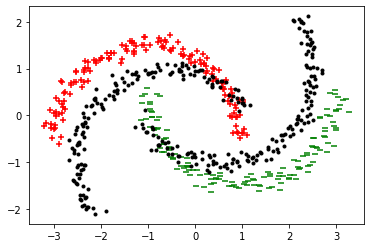

In [ ]:
pos_x = []
neg_x = []

for i in range(len(source_x)):
  if source_y[i] == 0:
    pos_x.append(source_x[i])
  else:
    neg_x.append(source_x[i])

plt.scatter([i[0] for i in pos_x], [i[1] for i in pos_x], marker = '+', color = 'red')
plt.scatter([i[0] for i in neg_x], [i[1] for i in neg_x], marker = '_', color = 'green')
plt.scatter([i[0] for i in target_x], [i[1] for i in target_x], marker = '.', color = 'black')
plt.show()

# Model

In [ ]:
class Model:
  def __init__(self, dim, hidden_size, label, learning_rate, dann, n_epochs):
    self.dim = dim
    self.hidden_size = hidden_size
    self.label = label
    self.W = np.random.rand(hidden_size, dim)
    self.b = np.zeros(hidden_size)
    self.V = np.random.rand(label, hidden_size)
    self.c = np.zeros(label)
    self.u = np.zeros(hidden_size)
    self.d = 0
    self.lr = learning_rate
    self.dann = dann
    self.n_epochs = n_epochs

  def sigmoid(self, x):
    return 1. / (1 + np.exp(-x)) 

  def softmax(self, x):
    return np.exp(x) / sum(np.exp(x))

  def one_hot(self, y):
    a = np.zeros(self.label)
    a[y] = 1
    return a

  def convert_to_matrix(self, x):
    return x.reshape(-1, 1)

  def fit(self, s_x, s_y, t_x):

    W, b, V, c, u, d, lr = self.W, self.b, self.V, self.c, self.u, self.d, self.lr

    lambda_ = 6
    n, n_ = len(s_x), len(t_x)
    for epoch in range(self.n_epochs):
      for i in range(n):
        # Forward Propagation
        gf = self.sigmoid(b + W @ s_x[i])
        gyf = self.softmax(c + V @ gf)

        # Backpropagation
        del_c = -(self.one_hot(s_y[i]) - gyf)
        del_V = self.convert_to_matrix(del_c) @ self.convert_to_matrix(gf).T
        del_b = (V.T @ del_c) * gf * (1 - gf)
        del_W = self.convert_to_matrix(del_b) @ self.convert_to_matrix(s_x[i]).T

        # Domain adaptation regularizer...
        # ...from current domain

        gdf = self.sigmoid(d + u.T @ gf)
        del_d = lambda_ * (1 - gdf)
        del_u = lambda_ * (1 - gdf) * gf

        tmp = lambda_ * (1 - gdf) * (u * gf * (1 - gf))
        if self.dann:
          del_b += tmp
          del_W += self.convert_to_matrix(tmp) @ self.convert_to_matrix(s_x[i]).T

        # ...from other domain  
        j = np.random.randint(n_)
        gfj = self.sigmoid(b + W @ t_x[j])
        gdfj = self.sigmoid(d + u.T @ gfj)
        del_d -= lambda_ * gdfj
        del_u -= lambda_ * gdfj * gfj
        
        tmp = -lambda_ * gdfj * u * gfj * (1 - gfj)
        if self.dann:
          del_b += tmp
          del_W += self.convert_to_matrix(tmp) @ self.convert_to_matrix(t_x[j]).T

        # Update neural network parameters
        W -= lr * del_W
        V -= lr * del_V
        b -= lr * del_b
        c -= lr * del_c

        # Update domain classifier
        u += lr * del_u
        d += lr * del_d

    self.W, self.b, self.V, self.c, self.u, self.d, self.lr = W, b, V, c, u, d, lr

  def predict(self, x):
    # x has dimension (#samples, dim)
    labels = []
    for i in range(len(x)):
      gf = self.sigmoid(self.b + self.W @ x[i])
      gyf = self.softmax(self.c + self.V @ gf)
      labels.append(np.argmax(gyf, axis = 0))
    return np.array(labels)

  def predict_domain(self, x):
    domains = []
    for i in range(len(x)):
      gf = self.sigmoid(self.b + self.W @ x[i])
      gdf = self.sigmoid(self.d + self.u.T @ gf)
      domains.append(1 if gdf < 0.5 else 0)
    return np.array(domains)

# Reference: https://github.com/GRAAL-Research/domain_adversarial_neural_network

# Standard NN

In [ ]:
model_simple = Model(2, 15, 2, 0.05, False, 200)
model_simple.fit(source_x, source_y, target_x)

In [ ]:
print('Simple NN:')
print('Source Accuracy:', (model_simple.predict(source_x) == source_y).sum() / len(source_x))
print('Target Accuracy:', (model_simple.predict(target_x) == target_y).sum() / len(target_x))

Simple NN:
Source Accuracy: 1.0
Target Accuracy: 0.8233333333333334


In [ ]:
import pickle
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/standard_nn_part_a.pt'

with open(model_path, 'wb') as f:
  pickle.dump(model_simple, f)

In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/standard_nn_part_a.pt'

with open(model_path, 'rb') as f:
  model_simple = pickle.load(f)

# Shallow DANN

In [ ]:
model_dann = Model(2, 15, 2, 0.05, True, 200)
model_dann.fit(source_x, source_y, target_x)

In [ ]:
print('Shallow DANN:')
print('Source Accuracy:', (model_dann.predict(source_x) == source_y).sum() / len(source_x))
print('Target Accuracy:', (model_dann.predict(target_x) == target_y).sum() / len(target_x))

Shallow DANN:
Source Accuracy: 1.0
Target Accuracy: 0.9666666666666667


In [ ]:
import pickle
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/shallow_dann_part_a.pt'

with open(model_path, 'wb') as f:
  pickle.dump(model_dann, f)

In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/shallow_dann_part_a.pt'

with open(model_path, 'rb') as f:
  model_dann = pickle.load(f)

# Graphs

In [ ]:
# Reference: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_classification(source_x, source_y, target_x, func, title, col_map):
  x_min = min(min(source_x[:, 0]), min(target_x[:, 0])) - 0.5
  x_max = max(max(source_x[:, 0]), max(target_x[:, 0])) + 0.5
  y_min = min(min(source_x[:, 1]), min(target_x[:, 1])) - 0.5
  y_max = max(max(source_x[:, 1]), max(target_x[:, 1])) + 0.5

  plt.title(title)
  plt.xlim((x_min, x_max))
  plt.ylim((y_min, y_max))

  step = 0.01
  x_coord = np.arange(x_min, x_max, step)
  y_coord = np.arange(y_min, y_max, step)

  xx, yy = np.meshgrid(x_coord, y_coord)

  Z = []
  for j in y_coord:
      lol = []
      for i in x_coord:
          lol.append(func(np.array([[i, j]]))[0])
      Z.append(np.array(lol))

  Z = np.array(Z)

  plt.contourf(xx, yy, Z, cmap = col_map, alpha = 0.2)
  plt.contour(xx, yy, Z, colors = 'black', linewidths = 3)

  pos_x = []
  neg_x = []

  for i in range(len(source_x)):
    if source_y[i] == 0:
      pos_x.append(source_x[i])
    else:
      neg_x.append(source_x[i])

  plt.scatter([i[0] for i in pos_x], [i[1] for i in pos_x], marker = '+', color = 'red')
  plt.scatter([i[0] for i in neg_x], [i[1] for i in neg_x], marker = '_', color = 'green')
  plt.scatter([i[0] for i in target_x], [i[1] for i in target_x], marker = '.', color = 'black')
  plt.show()

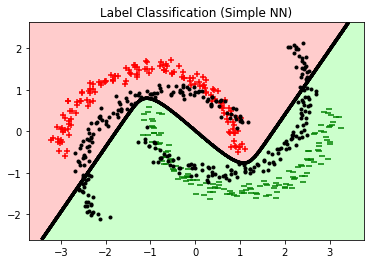

In [ ]:
plot_classification(source_x, source_y, target_x, model_simple.predict, 'Label Classification (Simple NN)', ListedColormap(['#FF0000', '#00FF00']))

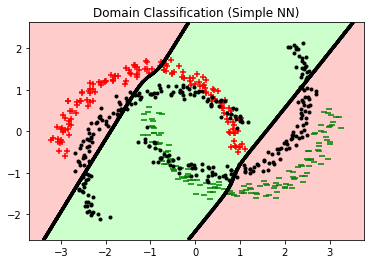

In [ ]:
plot_classification(source_x, source_y, target_x, model_simple.predict_domain, 'Domain Classification (Simple NN)', ListedColormap(['#FF0000', '#00FF00']))

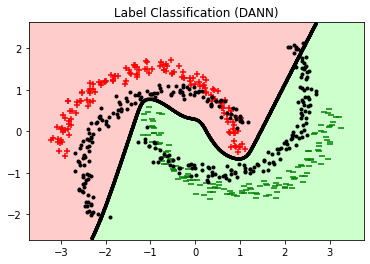

In [ ]:
plot_classification(source_x, source_y, target_x, model_dann.predict, 'Label Classification (DANN)', ListedColormap(['#FF0000', '#00FF00']))

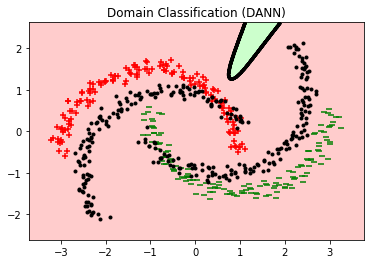

In [ ]:
plot_classification(source_x, source_y, target_x, model_dann.predict_domain, 'Domain Classification (DANN)', ListedColormap(['#FF0000', '#00FF00']))